# Vision por Computadora I - CEIA

## Trabajo Practico N° 3

#### Autor: Juan Ignacio Ribet

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [187]:
#%matplotlib qt

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

Para que la detección sea invariante a la escala lo primero que voy a hacer es escalar el témplate para que su ancho sea igual al ancho de la imagen, luego voy a ir reduciendo la escala del témplate en forma progresiva buscando el tamaño en el que se logre un máximo en la detección.

Abajo muestro las imágenes luego del preprocesamiento para empezar a hacer la comparación con 'cv.matchTemplate'.


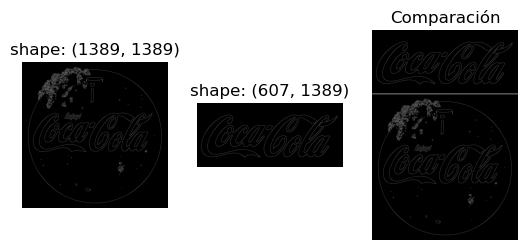

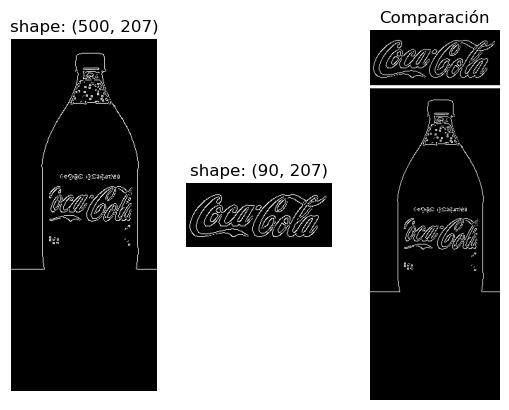

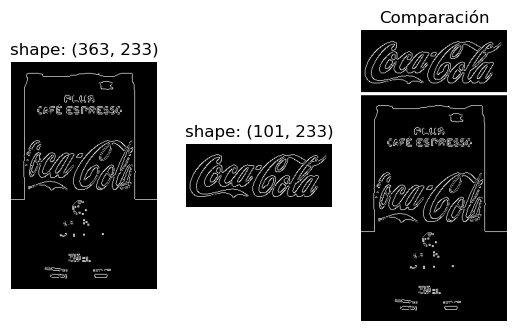

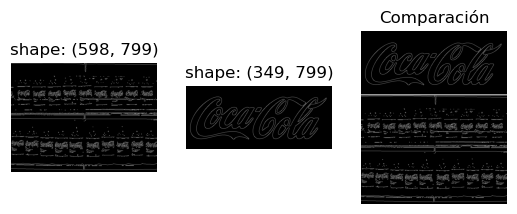

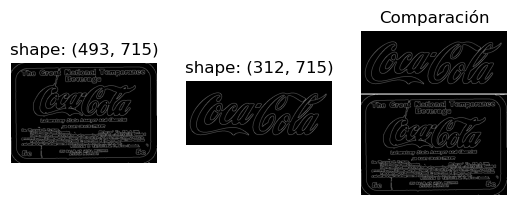

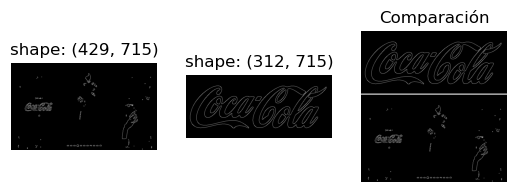

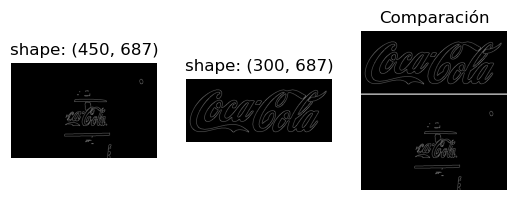

In [327]:
template = cv.imread('template\pattern.png',0)

for imagePath in glob.glob('images/**'):
	# Cargo las imagen y le aplico el preprocesamiento. 
	image = cv.imread(imagePath)
	gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
	_,gray1 = cv.threshold(gray.copy(),200,255,cv.THRESH_BINARY)
	edges = cv.Canny(gray1.copy(), 50, 200)
	h, w = gray.shape
	
	# Cargo el template y le aplico el preprocesamiento.	
	template1 = cv.resize(template, [int(w), int(w*0.4375)])
	_,temp = cv.threshold(template1,200,255,cv.THRESH_BINARY)
	template_edges = cv.Canny(temp, 50, 200)	
	ht, wt = template_edges.shape
	
	# Uno las imagenes para comparar tamaños
	new = np.zeros((h+ht, wt))
	new[0: ht, 0: wt] = template_edges
	new[ht: ht+h, 0: wt] = edges
	new = cv.line(new, (0, ht), (wt, ht), 255, 3)

	plt.figure()
	plt.subplot(131),plt.title(f'shape: {edges.shape}'); plt.axis('off');plt.imshow(edges, cmap='gray')
	plt.subplot(132),plt.title(f'shape: {template_edges.shape}'); plt.axis('off');plt.imshow(template_edges, cmap='gray')
	plt.subplot(133),plt.title('Comparación'); plt.axis('off');plt.imshow(new, cmap='gray')
	plt.show()



Realizo un bucle por cada imagen en cada método de 'cv.matchTemplate' en escalas desde el 100% al 15% del tamaño del témplate. Arrancando como ya lo indiqué antes con el ancho del témplate igual al ancho de la imagen.

Luego grafico los valores máximos de cada comparación en relación con la escala del témplate.

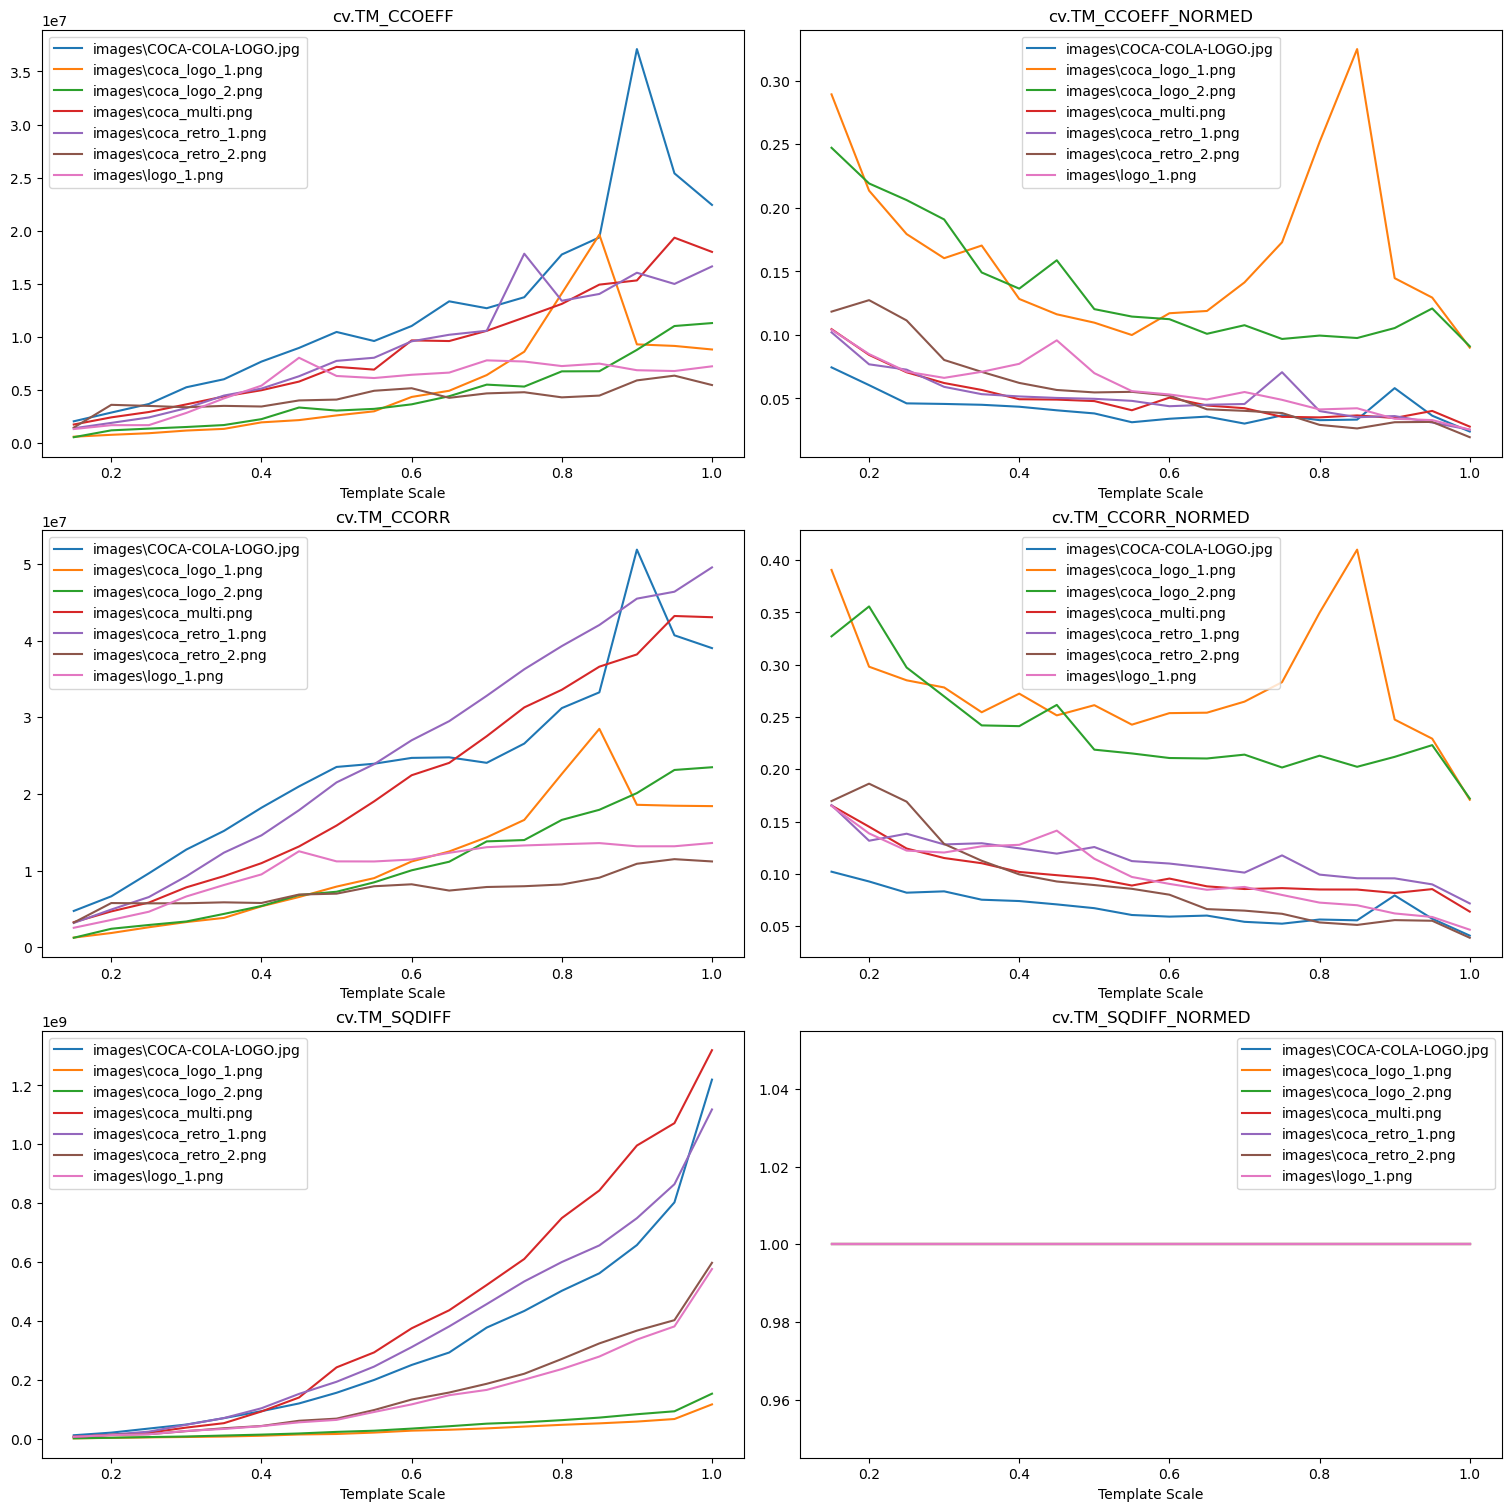

In [324]:
val_list = {}

methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

fig, axs = plt.subplots(3, 2, figsize=(15, 15), layout='constrained')

for imagePath in glob.glob('images/**'):
    # Cargo las imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _,gray1 = cv.threshold(gray.copy(),200,255,cv.THRESH_BINARY)
    edges = cv.Canny(gray1.copy(), 50, 200)
    h, w = gray.shape

    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)    
    template = cv.resize(template, [int(w), int(w*0.4375)])
    _,template1 = cv.threshold(template.copy(),200,255,cv.THRESH_BINARY_INV)
    template_edges = cv.Canny(template1.copy(), 50, 200)

    # Bucle por cada metodo.
    for meth, ax in zip(methods, axs.flat):
        method = eval(meth)

        # Bucle por las escalas de tamaño de template de 100% a 15%.
        for scale in np.linspace(0.15, 1.0, 18)[::-1]:

            # Modificacion de tamaño a la escala determinada.
            ht, wt = template_edges.shape
            temp_res = cv.resize(template_edges.copy(), [int(wt * scale), int(ht * scale)])
            
            # Aplicamos la coincidencia de patrones.
            result = cv.matchTemplate(edges, temp_res, method)
            # Encontramos los valores máximos y mínimos.
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            # Guardamos los valores maximo y la escala.
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                val_list[round(scale,2)] = min_val     
            else:
                val_list[round(scale,2)] = max_val
        
        # Graficamos.
        ax.set_title(meth)
        ax.plot(val_list.keys(), val_list.values(),label=imagePath)
        ax.set_xlabel('Template Scale')
        ax.legend()

En principio no se ve un método donde se pueda distinguir máximos en cada imagen.

Ahora tomo el máximo de cada método y grafico el rectángulo de la detección en las imágenes para verificar lo que se ve en los gráficos.

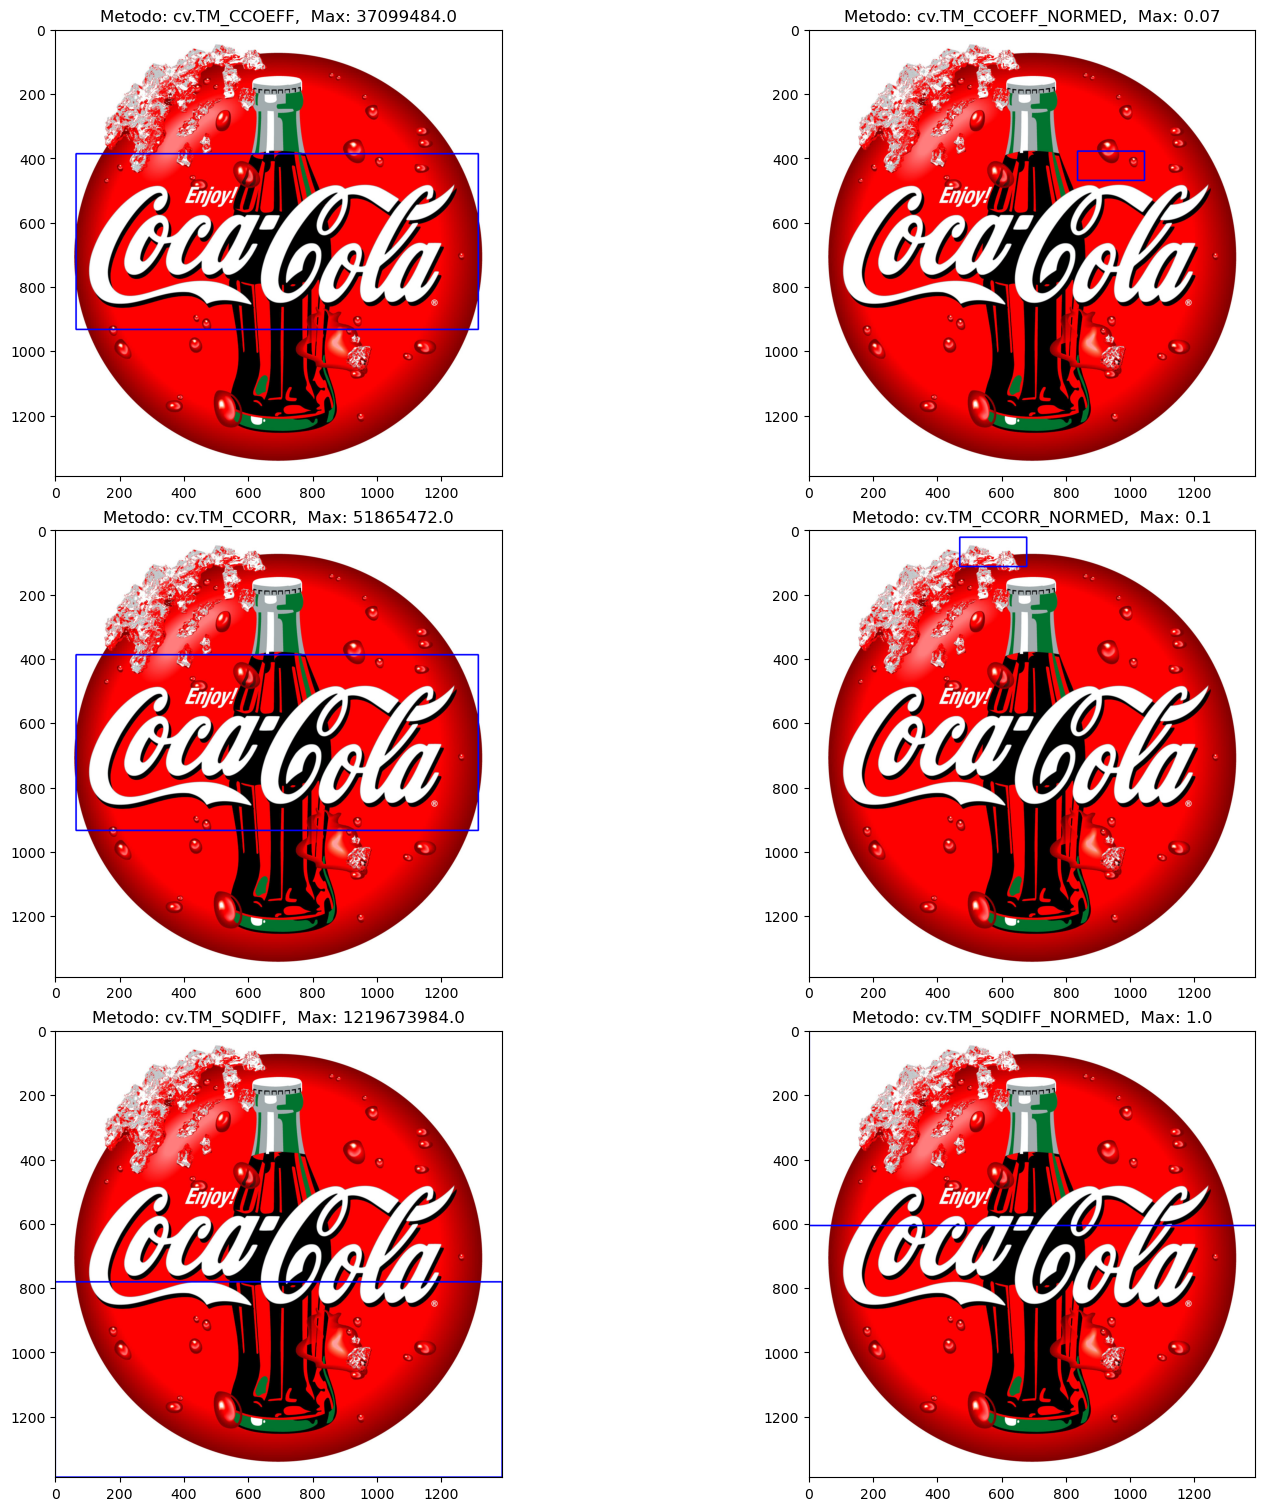

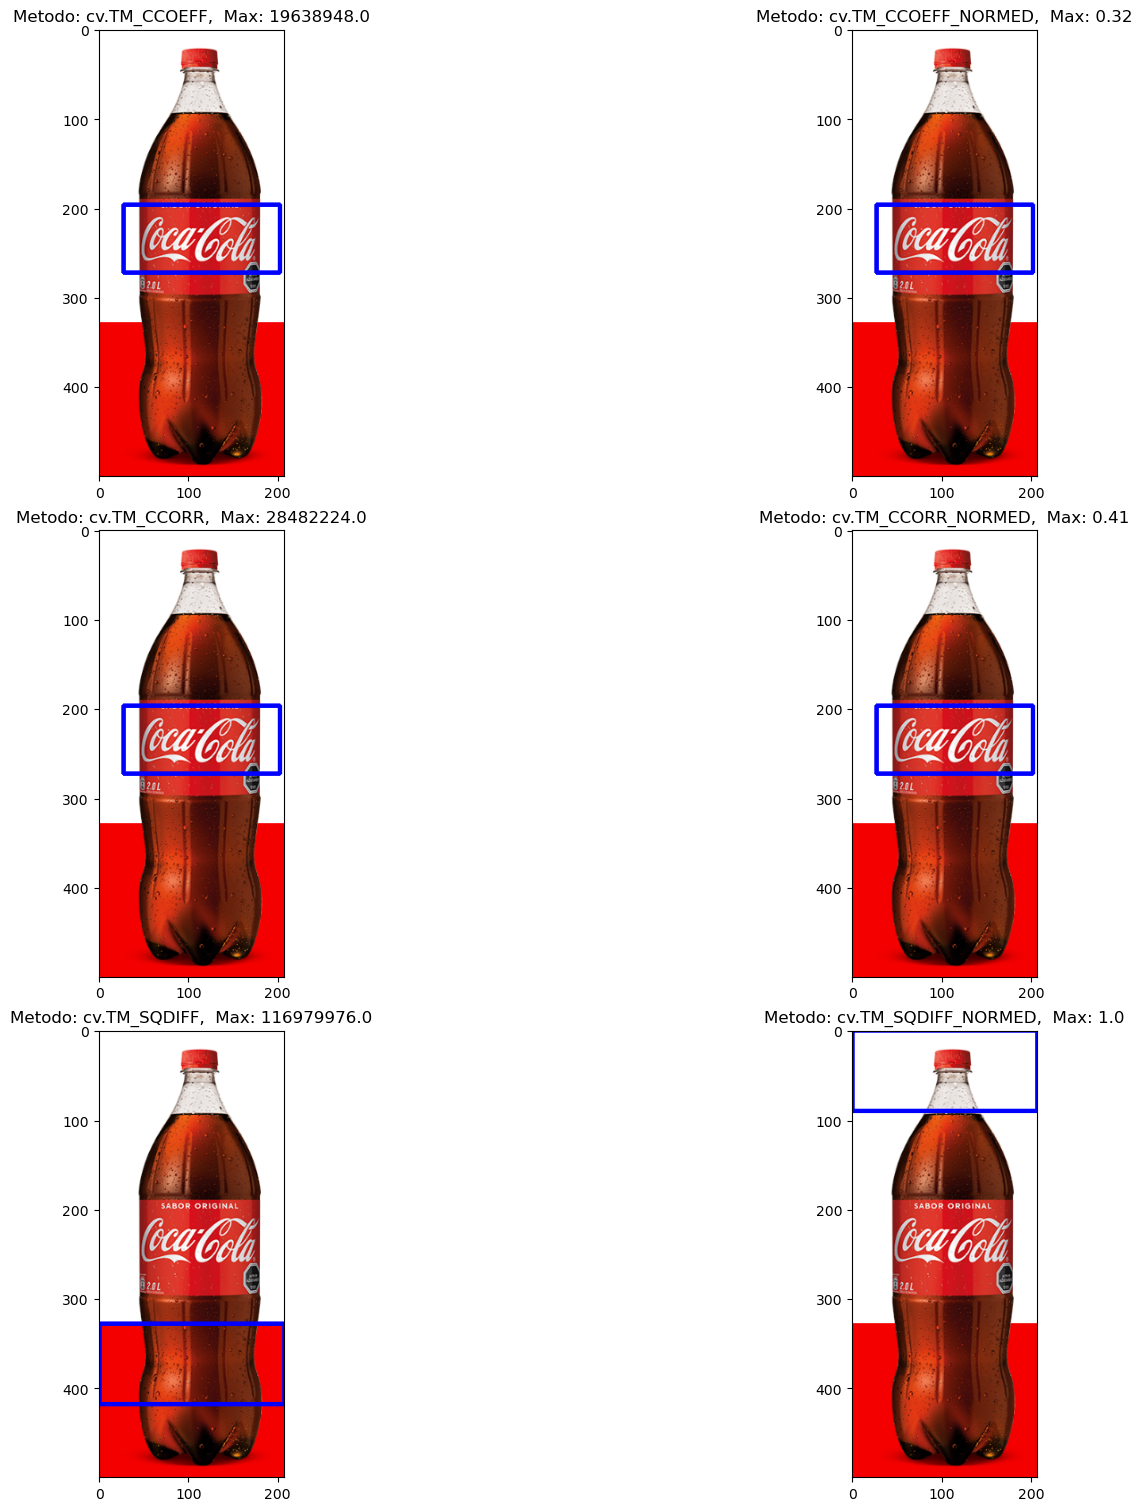

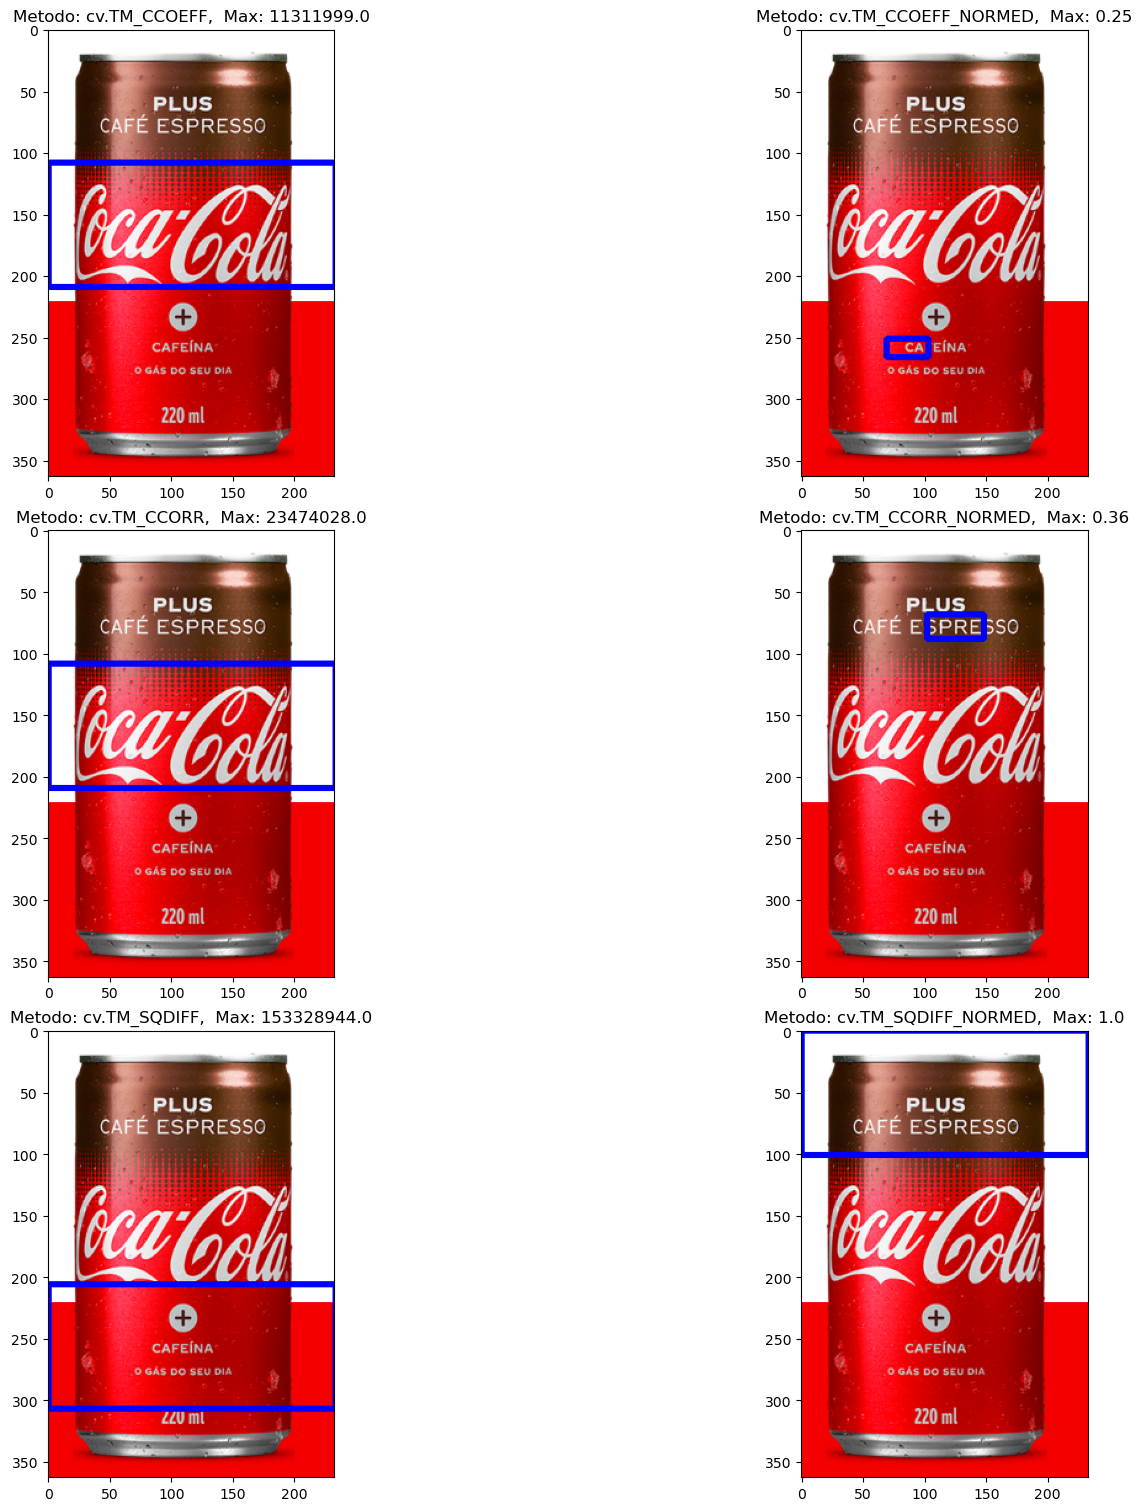

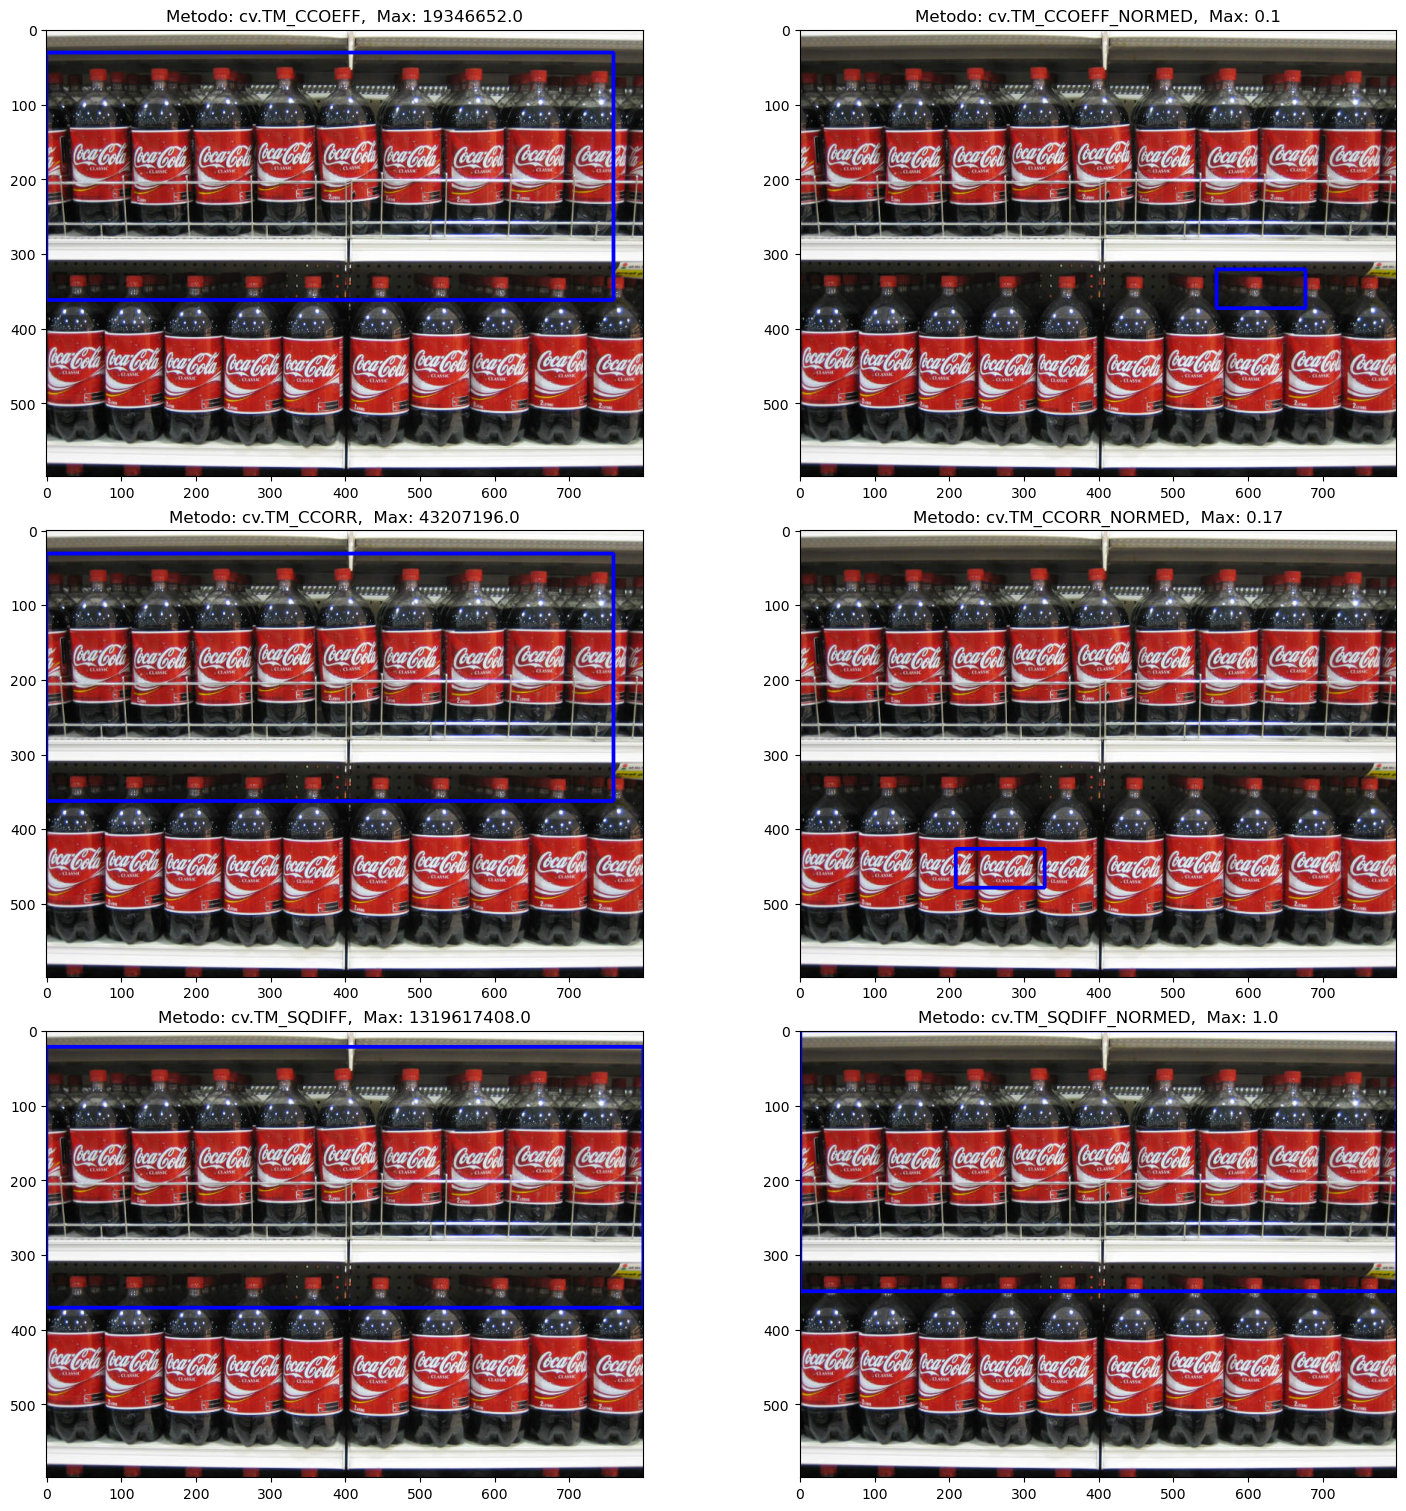

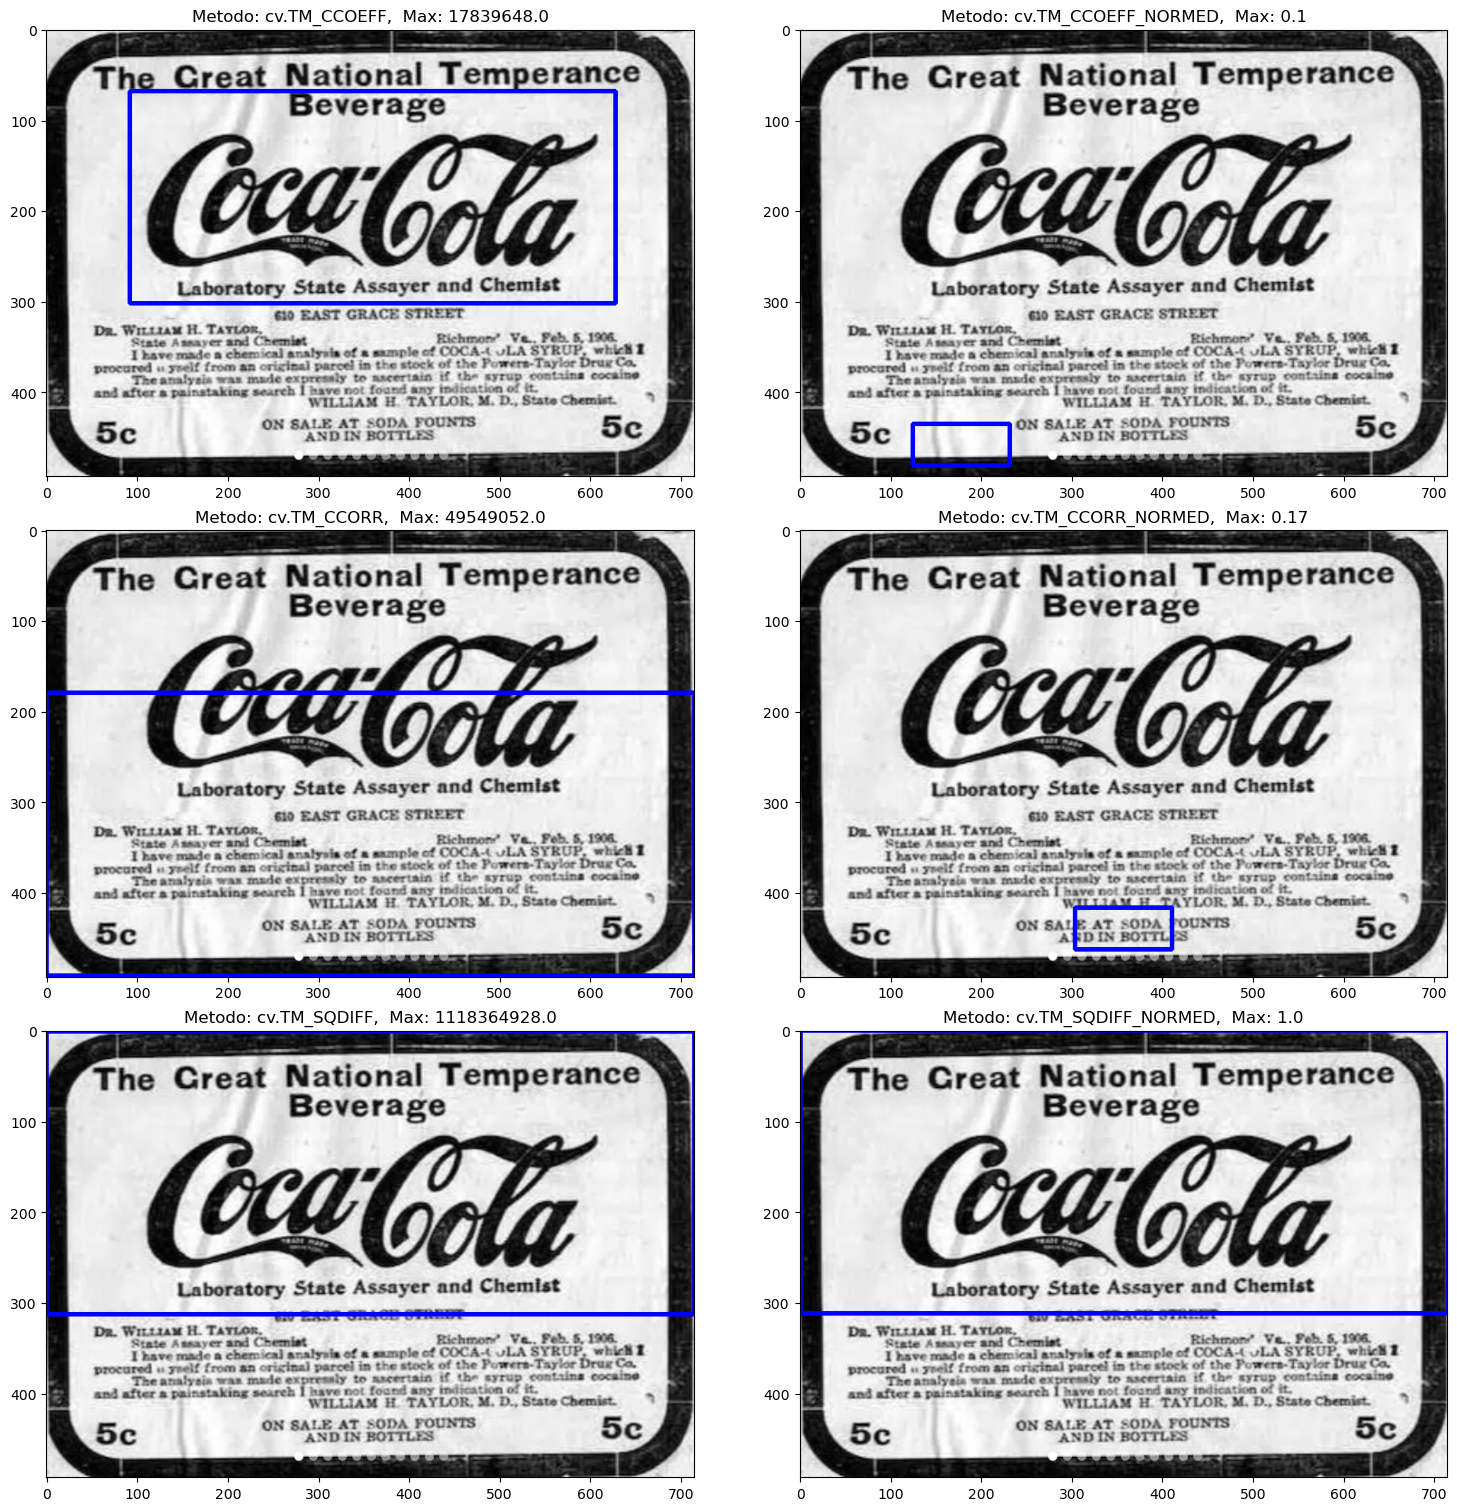

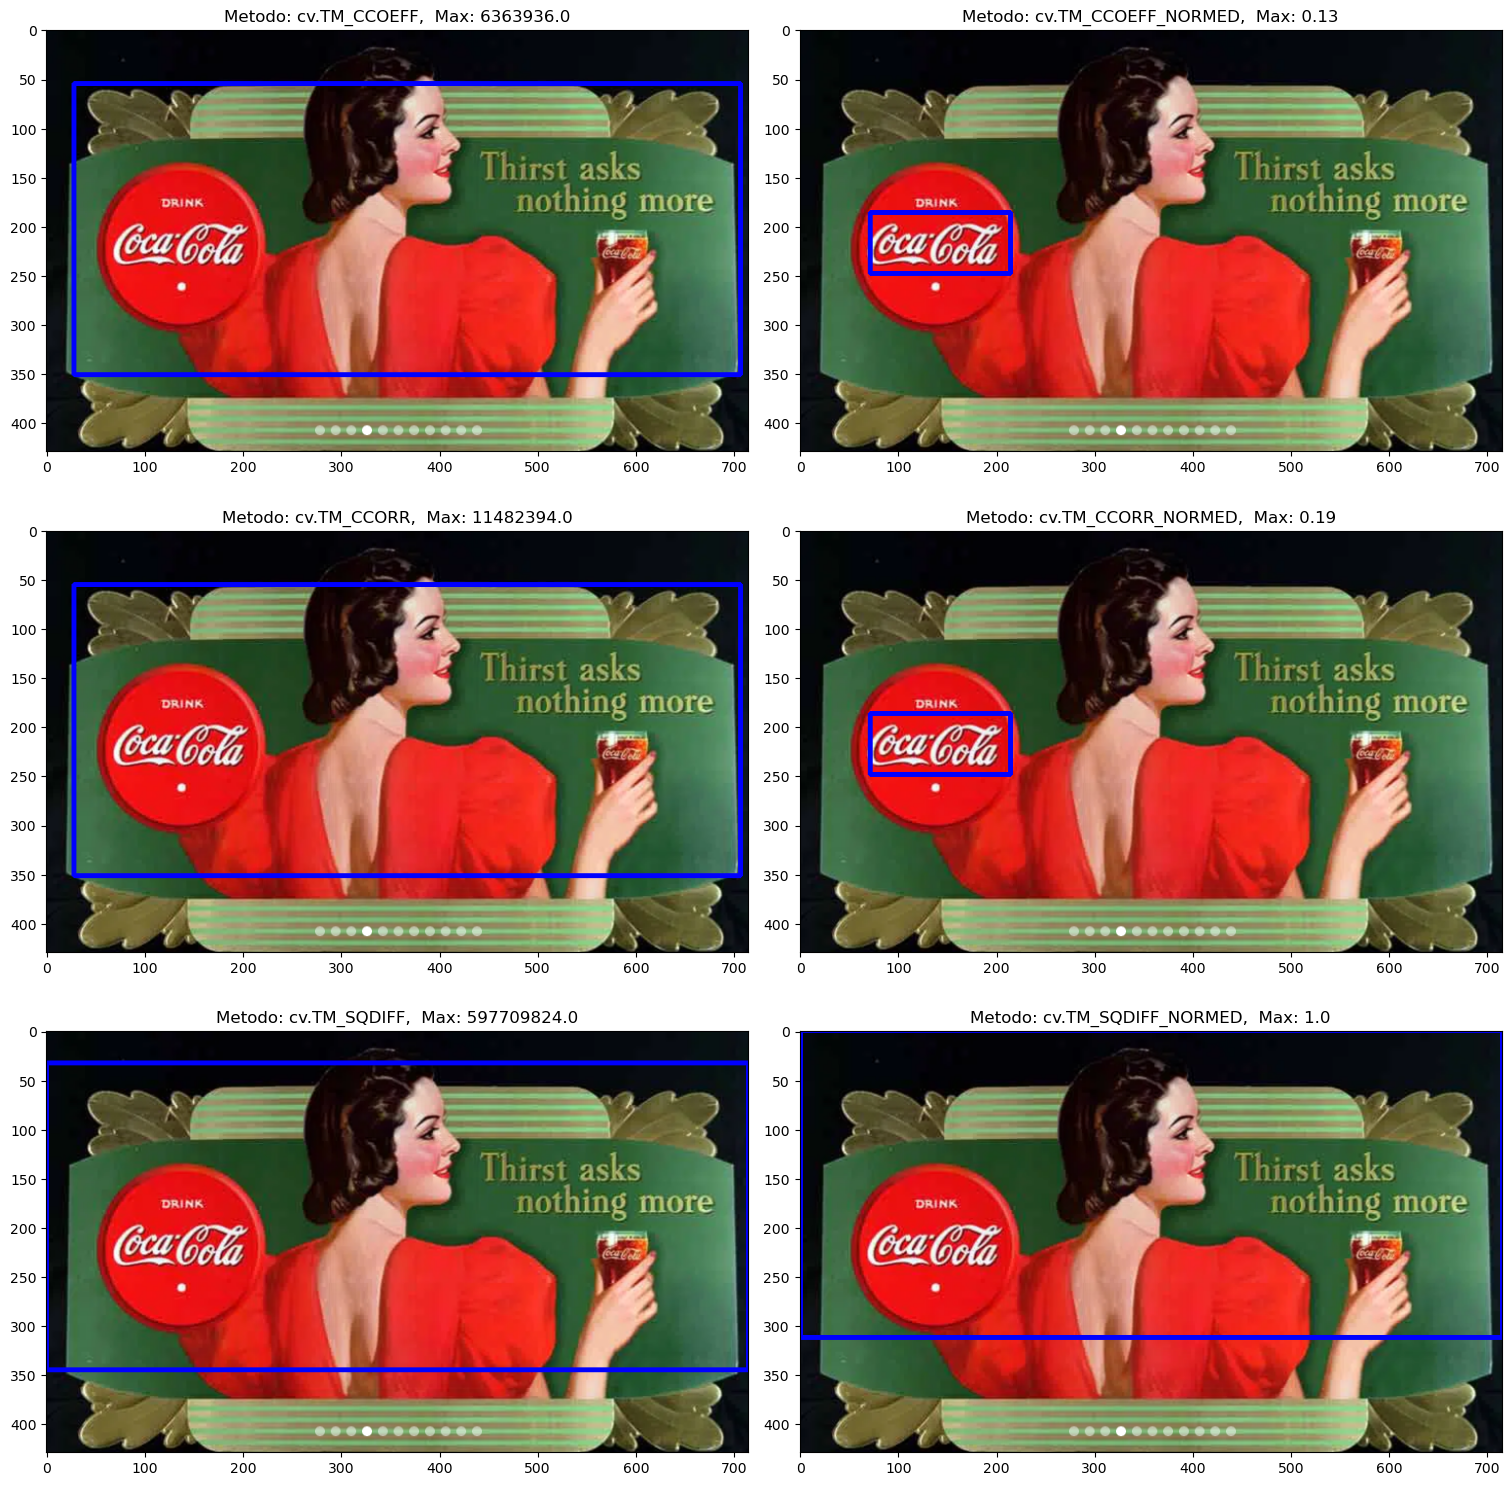

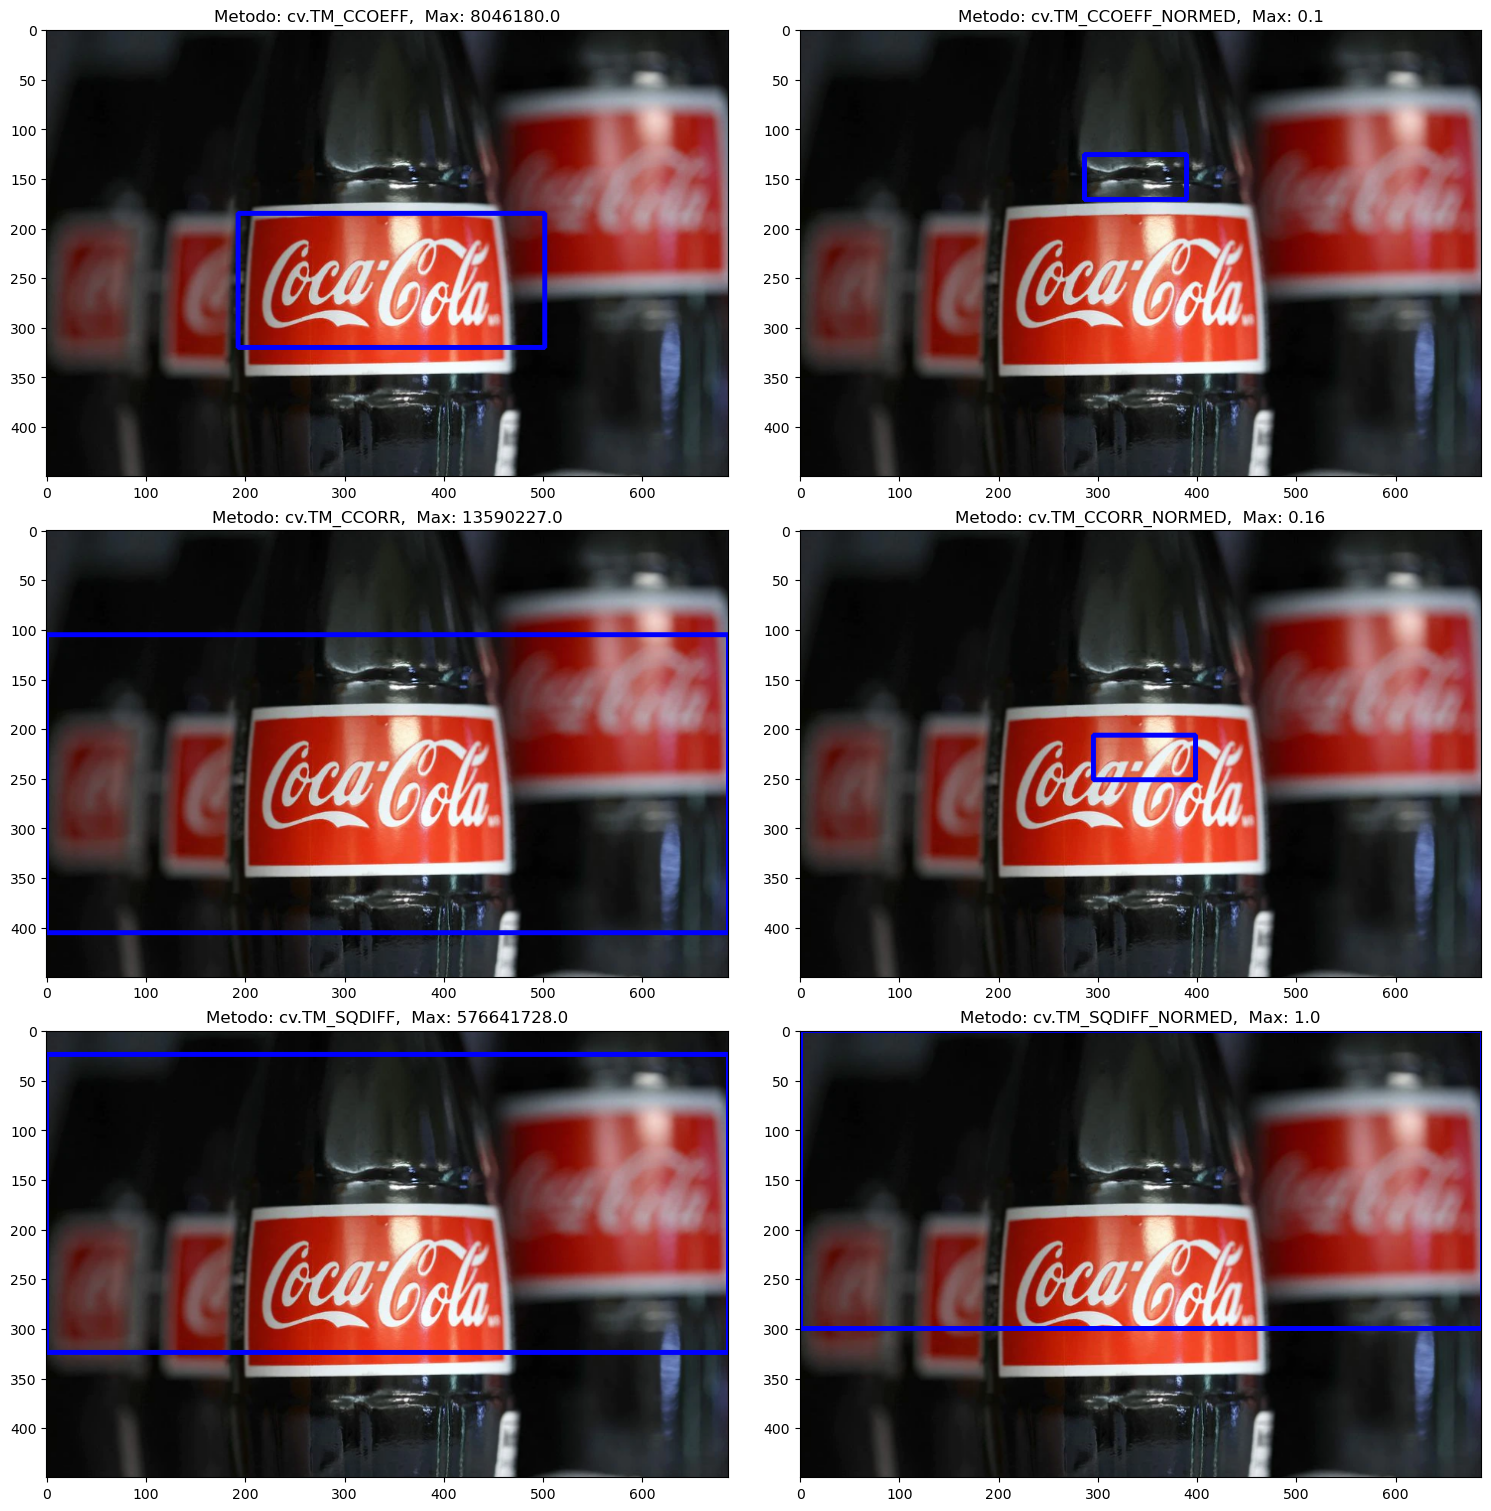

In [321]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

# Cargamos cada imagen.
for imagePath in glob.glob('images/**'):

    # Cargo las imagen y le aplico el preprocesamiento.
    image = cv.imread(imagePath)
    gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
    _,gray1 = cv.threshold(gray.copy(),200,255,cv.THRESH_BINARY)
    edges = cv.Canny(gray1.copy(), 50, 200)
    h, w = gray.shape
    
    # Cargo el template y le aplico el preprocesamiento.
    template = cv.imread('template\pattern.png',0)    
    template = cv.resize(template, [int(w), int(w*0.4375)])
    _,template1 = cv.threshold(template.copy(),200,255,cv.THRESH_BINARY_INV)
    template_edges = cv.Canny(template1.copy(), 50, 200)
    

    fig, axs = plt.subplots(3, 2, figsize=(15, 15), layout='constrained')
    
    # Bucle por cada metodo.
    for meth, ax in zip(methods, axs.flat):
        #inicializamos la lista de valores maximos en cada escala.
        val_list = []
        method = eval(meth)
        
        # Bucle por las escalas de tamaño de template de 100% a 15%.
        for scale in np.linspace(0.15, 1.0, 18)[::-1]:

            img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)

            # Modificacion de tamaño a la escala determinada.
            wt, ht = template1.shape
            temp_res_heigth = int(ht * scale)
            temp_res_width = int(wt * scale)

            temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])


            # Aplicamos la coincidencia de patrones.
            result = cv.matchTemplate(edges, temp_res, method)
            # Encontramos los valores máximos y mínimos.
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            # Guardamos los valores maximo, la ubicaion y el tamaño del template.
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                val_list.append([min_val, min_loc, temp_res_width, temp_res_heigth])   
            else:
                val_list.append([max_val, max_loc, temp_res_width, temp_res_heigth])

        # Obtenemos el valor máximo de todas las escalas.
        max_value = max([val_list[x][0] for x in range(len(val_list))])
        x = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
        top_left = val_list[x[0]][1]


        # Marcamos el lugar donde lo haya encontrado.
        bottom_right = (top_left[0] + val_list[x[0]][3], top_left[1] + val_list[x[0]][2])
        cv.rectangle(img_rgb,top_left, bottom_right, (0,0,255), 3)
      
        ax.set_title(f'Metodo: {meth},  Max: {round(max_value,2)}')
        ax.imshow(img_rgb)


Lo que se puede ver es que no hay ningun metodo que funcione en todas las imagenes, se puede realizar las detecciones pero usando un metodo especifico para cada imagen.

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

Con la misma metodologia del punto uno obtengo la escala ideal para las detecciones y luego aplico un 'threshold' para obtener multiples deteciones. 
Utizo el metodo 'cv.TM_CCORR_NORMED' que fue el que mejor resultado dio en la imagen en el ejercicio 1.

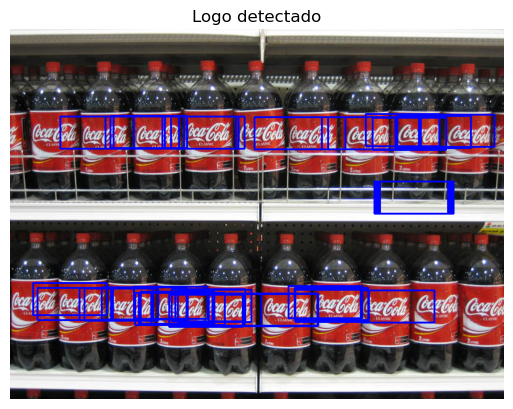

In [ ]:
# Cargo las imagen y le aplico el preprocesamiento.
image = cv.imread('images\coca_multi.png')
img_rgb= cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
_,gray1 = cv.threshold(gray.copy(),200,255,cv.THRESH_BINARY)
edges = cv.Canny(gray1.copy(), 50, 200)
h, w = gray.shape

# Cargo el template y le aplico el preprocesamiento.
template = cv.imread('template\pattern.png',0)    
template = cv.resize(template, [int(w), int(w*0.4375)])
_,template1 = cv.threshold(template.copy(),200,255,cv.THRESH_BINARY_INV)
template_edges = cv.Canny(template1.copy(), 50, 200)
wt, ht = template1.shape

# Bucle por las escalas de tamaño de template de 100% a 15%.
for scale in np.linspace(0.10, 1.0, 19)[::-1]:
    # Modificacion de tamaño a la escala determinada.   
    temp_res_heigth = int(ht * scale)
    temp_res_width = int(wt * scale)
    temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])

    # Aplicamos la coincidencia de patrones.
    result = cv.matchTemplate(edges, temp_res, cv.TM_CCORR_NORMED)

    # Encontramos los valores máximos y mínimos.
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    # Guardamos los valores maximo y la escala.
    val_list.append([max_val, scale])

# Obtenemos la escala para la cual se obtuvo el valor maximo.
max_value = max([val_list[x][0] for x in range(len(val_list))])
x = [x for x in range(len(val_list)) if val_list[x][0] == max_value]
scale_op = val_list[x[0]][1]

#Aplicamos los patrones de coincidencia a la escala obtenida.
temp_res_heigth = int(ht * scale_op)
temp_res_width = int(wt * scale_op)
temp_res = cv.resize(template_edges.copy(), [temp_res_heigth, temp_res_width])
result = cv.matchTemplate(edges, temp_res, cv.TM_CCORR_NORMED)

# Fijamos un umbral de "coincidencia" de 80% del valor máximo.
threshold = 0.8 * max_value
loc = np.where( result > threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0]+temp_res_heigth , pt[1]+temp_res_width), (0,0,255), 2)

# Imagen original con recuadro.
plt.figure()
plt.imshow(img_rgb)
plt.title('Logo detectado'); plt.axis('off')
plt.show()